In [1]:
import pandas as pd
from cleaning import create_demand
import pyomo.environ as pyo
import pyomo
import numpy as np

# Data import

In [2]:
nodes = pd.read_pickle("../../data/original/nodes.pkl")
channels = pd.read_pickle("../../data/original/channels.pkl")

## Modeling

In [3]:
pyomo.common.timing.report_timing()

In [4]:
# Multiplication to set the same base unit for all computations
channels["capacity"] = channels["capacity"] * 1000000
channels["base_fee"] = channels["base_fee"] * 1000000

In [5]:
model = pyo.ConcreteModel(name="Min cost flow problem")
model.NODES = pyo.Set(initialize=nodes.index)
model.CHANNELS = pyo.Set(initialize=[(channels.loc[i, "node1_pub"], channels.loc[i, "node2_pub"]) for i in channels.index])

           0 seconds to construct Block ConcreteModel; 1 index total
        0.02 seconds to construct Set NODES; 1 index total
        0.34 seconds to construct Set CHANNELS; 1 index total


In [6]:
transaction_amount = 200000
nodes = create_demand(nodes, transaction_amount,
                      source="02b4098c3116124c0c4105295d3d2e65927d46e98e248d84cb6119da57e4ae31e3",destination="0202f00d5f5c91a3c79113851b162c2b75f2cbd9fb2378fb4a4ce92d5ba1e63e08")

Transaction of 200000 sats.
Sender: VeniceForever
Receiver: ShatSat412.


In [7]:
model.x = pyo.Var(model.CHANNELS, domain=pyo.NonNegativeIntegers, bounds=(0,1))
model.a = pyo.Var(model.CHANNELS, domain=pyo.NonNegativeReals, bounds=(0, max(nodes["demand"])))

        0.12 seconds to construct Var x; 89898 indices total
        0.11 seconds to construct Var a; 89898 indices total


In [8]:
channels.reset_index(inplace=True)
channels.set_index(["node1_pub", "node2_pub"], inplace=True)
channels.sort_index(inplace=True)

### Objective function

$$
min \sum_{} ^{} amount_i \times feerate_{i} + x_{i} \times basefee_{i} \times \frac{1}{Prob}
$$

In [30]:
## Uniform distribution
channels["prob"] = np.random.uniform(low=0, high=channels["capacity"])/channels["capacity"]

In [29]:
channels

channel_id  \
node1_pub                                                          node2_pub                                                                                   
0200000000727d3b67513c916f16975e3bf8f3304cf3fcf0ed855e2ae41888f461 0360a41eb8c3fe09782ef6c984acbb003b0e1ebc4fe10ae01bab0e80d76618c8f4     914492408312299520   
0200000000a3eff613189ca6c4070c89206ad658e286751eca1f29262948247a5f 02e4971e61a3f55718ae31e2eed19aaf2e32caf3eb5ef5ff03e01aa3ada8907e78     858567948297371650   
                                                                   02f1a8c87607f415c8f22c00593002775941dea48869ce23096af27b0cfdcc0b69     838135723780210689   
                                                                   02f460ae6d3d3e104f8afe520ae0cff3d94c35c2ba8df66da89f3c8006a265b90a     837978493509959681   
020003b9499a97c8dfbbab6b196319db37ba9c37bccb60477f3c867175f417988e 0205198c099c45acedf988445f71da087ca39cd80847e53a7819e8f4e45768d7d3     906034964784021504   
...                                                                                                                                                      ...   
03ffc95f28306c88f5c033774ac5e59c30f6cc91e76af6cd65769803e918942352 02cc79b8d771cc79d323bd71e54ef1780cab50e7c0ef2a4beb625fc9dcbbcc6d24  INV865354134044606465   
                                                                   02f1a8c87607f415c8f22c00593002775941dea48869ce23096af27b0cfdcc0b69  INV865369527244357633   
03ffcd6f3e5880b2ce51de42ab922ec3c224fc47843396d84b2314c3fcbdb8bf85 0217890e3aad8d35bc054f43acc00084b25229ecff0ab68debd82883ad65ee8266  INV770366225064394752   
                                                                   028c8c9b0b588d00afabe905799aee0225a9315cdb63d7646b7ff7cf02fe4bf643  INV770918179822239744   
                                                                   02a04446caa81636d60d63b066f2814cbd3a6b5c258e3172cbdded7a16e2cfff4c  INV770630107742011392   

                                                                                                                                       rate_fee  \
node1_pub                                                          node2_pub                                                                      
0200000000727d3b67513c916f16975e3bf8f3304cf3fcf0ed855e2ae41888f461 0360a41eb8c3fe09782ef6c984acbb003b0e1ebc4fe10ae01bab0e80d76618c8f4  0.000050   
0200000000a3eff613189ca6c4070c89206ad658e286751eca1f29262948247a5f 02e4971e61a3f55718ae31e2eed19aaf2e32caf3eb5ef5ff03e01aa3ada8907e78  0.000000   
                                                                   02f1a8c87607f415c8f22c00593002775941dea48869ce23096af27b0cfdcc0b69  0.000100   
                                                                   02f460ae6d3d3e104f8afe520ae0cff3d94c35c2ba8df66da89f3c8006a265b90a  0.000048   
020003b9499a97c8dfbbab6b196319db37ba9c37bccb60477f3c867175f417988e 0205198c099c45acedf988445f71da087ca39cd80847e53a7819e8f4e45768d7d3  0.000200   
...                                                                                                                                         ...   
03ffc95f28306c88f5c033774ac5e59c30f6cc91e76af6cd65769803e918942352 02cc79b8d771cc79d323bd71e54ef1780cab50e7c0ef2a4beb625fc9dcbbcc6d24  0.000163   
                                                                   02f1a8c87607f415c8f22c00593002775941dea48869ce23096af27b0cfdcc0b69  0.000100   
03ffcd6f3e5880b2ce51de42ab922ec3c224fc47843396d84b2314c3fcbdb8bf85 0217890e3aad8d35bc054f43acc00084b25229ecff0ab68debd82883ad65ee8266  0.000001   
                                                                   028c8c9b0b588d00afabe905799aee0225a9315cdb63d7646b7ff7cf02fe4bf643  0.000001   
                                                                   02a04446caa81636d60d63b066f2814cbd3a6b5c258e3172cbdded7a16e2cfff4c  0.000600   

                                                                                                                                        base_fee  \
node1

In [10]:
#def objective_function(model: pyo.ConcreteModel):
#    return sum(model.a[i] * channels.loc[i, "rate_fee"] for i in model.CHANNELS) + sum(model.x[i] * channels.loc[i, "base_fee"] for i in model.CHANNELS)

def objective_function(model: pyo.ConcreteModel):
    return sum(model.a[i] * channels.loc[i, "rate_fee"] + model.x[i] * channels.loc[i, "base_fee"] + (1/channels.loc[i, "prob"]) for i in model.CHANNELS)

model.totalCost = pyo.Objective(rule=objective_function(model), sense=pyo.minimize)

           0 seconds to construct Objective totalCost; 1 index total


### Constraints


#### Capacity constraint

$$amount_{i,j} \le capacity_{i,j} \times x_{i,j} \text{ } \forall (i,j) \in E$$

In [11]:
def capacity_constraint(model: pyo.ConcreteModel, a, b):
    return model.a[(a, b)] <= channels.loc[(a, b), "capacity"] * model.x[(a, b)]

model.CapacityConstraint = pyo.Constraint(model.CHANNELS, rule=capacity_constraint, name="Capacity constraint")

        5.03 seconds to construct Constraint CapacityConstraint; 89898 indices total


#### Flow balance constraint

$$\sum_{(s,i) \in E} amount_{s,i} - \sum_{(i,t) \in E} amount_{i,d} = b_i \text{ } \forall i \in V$$

where $s$ is the source node, $d$ is the destination node, $i$ is every intermediary node


In [12]:
channels.reset_index(inplace=True)
channels.set_index("channel_id", inplace=True)

def flow_balance_constraint(model: pyo.ConcreteModel, n: str):
    InFlow = sum(model.a[(channels.loc[a, "node1_pub"], channels.loc[a, "node2_pub"])] for a in nodes.loc[n, 'incoming_channels'])
    OutFlow = sum(model.a[(channels.loc[a, "node1_pub"], channels.loc[a, "node2_pub"])] for a in nodes.loc[n, 'outgoing_channels'])
    return  OutFlow + nodes.loc[n, "demand"] == InFlow

model.FlowBalanceConstraint = pyo.Constraint(model.NODES, rule=flow_balance_constraint, name="Flow balance constrain")

channels.reset_index(inplace=True)
channels.set_index(["node1_pub", "node2_pub"], inplace=True)
channels.sort_index(inplace=True) 

        3.36 seconds to construct Constraint FlowBalanceConstraint; 11984 indices total


## Solving the model

In [13]:
#from pyomo.common.tempfiles import TempfileManager
#TempfileManager.tempdir = "/home/filippo/repositories/LN-pathfinding"

In [14]:
opt = pyo.SolverFactory('cbc')
#opt = pyo.SolverFactory('cplex_direct')
results = opt.solve(model, tee=True, keepfiles=True)

if (results.solver.status == pyo.SolverStatus.ok) and (results.solver.termination_condition == pyo.TerminationCondition.optimal):
    print('\nOptimal solution found')
elif results.solver.termination_condition == pyo.TerminationCondition.feasible:
    print('\nFeasible but not proven optimal solution found')
elif results.solver.termination_condition == pyo.TerminationCondition.infeasible:
    raise Exception("The model is infeasible")
else:
    print('\nSolver Status: ',  results.solver.status)
    raise Exception(results.solver.status)

print('\nObject function value = ', model.Objective())


           0 seconds to construct Var ONE_VAR_CONSTANT; 1 index total
      [    2.19] Generated LP representation
Solver log file: '/tmp/tmpkj1azmbi.cbc.log'
Solver solution file: '/tmp/tmpyfrbukao.pyomo.soln'
Solver problem files: ('/tmp/tmpyfrbukao.pyomo.lp',)
Welcome to the CBC MILP Solver 
Version: 2.10.8 
Build Date: May  9 2022 

command line - /usr/bin/cbc -printingOptions all -import /tmp/tmpyfrbukao.pyomo.lp -stat=1 -solve -solu /tmp/tmpyfrbukao.pyomo.soln (default strategy 1)
Option for printingOptions changed from normal to all
Presolve 61043 (-40839) rows, 138206 (-41591) columns and 265393 (-93649) elements
Statistics for presolved model
Original problem has 89898 integers (89898 of which binary)
Presolved problem has 55058 integers (55058 of which binary)
==== 6362 zero objective 3865 different
==== absolute objective values 3865 different
==== for integers 0 zero objective 967 different
==== for integers absolute objective values 967 different
===== end objective counts

In [15]:
#from pyomo.opt import SolverStatus, TerminationCondition

print("Solver Status: ",  results.solver[0]["System time"])


Solver Status:  3.15


In [16]:
from decimal import Decimal
pd.set_option('display.max_colwidth', 10000000000000000000000000000000000000000000000000000)
DF_channels = pd.DataFrame()
c = 0
for index, value in model.a.extract_values().items():
    if value > 0.1:
        DF_channels.loc[c, "source"] = index[0]
        DF_channels.loc[c, "destination"] = index[1]
        try:
            DF_channels.loc[c, "source-alias"] = nodes.loc[index[0], "alias"]
        except KeyError:
            print("Source alias not found in nodes database: placeholder inserted")
            DF_channels.loc[c, "source-alias"] = "source-alias"
            pass
        try:
            DF_channels.loc[c, "destination-alias"] = nodes.loc[index[1], "alias"]
        except KeyError:
            print("Destination alias not found in nodes database: placeholder inserted")
            DF_channels.loc[c, "destination-alias"] = "destination-alias"
            pass
        DF_channels.loc[c, "capacity"] = Decimal(channels.loc[index, "capacity"]/1000000)
        DF_channels.loc[c, "amount"] = Decimal(value/1000000)
        DF_channels.loc[c, "base_fee"] = Decimal(channels.loc[(index[0], index[1]), "base_fee"]/1000000)
        DF_channels.loc[c, "rate_fee"] = channels.loc[(index[0], index[1]), "rate_fee"]
        #DF_channels.loc[c, "used_fl"] = channels.loc[]
        c += 1

DF_channels_pos = DF_channels[DF_channels["amount"]!=0]

In [17]:
DF_channels[DF_channels["amount"]> DF_channels["capacity"]]

,source,destination,source-alias,destination-alias,capacity,amount,base_fee,rate_fee


In [18]:
DF_fixed = pd.DataFrame()
c = 0
for index, value in model.x.extract_values().items():
    if value != 0:
        DF_fixed.loc[c, "source"] = index[0]
        DF_fixed.loc[c, "destination"] = index[1]
        DF_fixed.loc[c, "used"] = Decimal(value)
        c += 1

DF_fixed_pos = DF_fixed[DF_fixed["used"]!=0]
DF_fixed_pos

,source,destination,used
0,0200000000a3eff613189ca6c4070c89206ad658e286751eca1f29262948247a5f,02e4971e61a3f55718ae31e2eed19aaf2e32caf3eb5ef5ff03e01aa3ada8907e78,1
1,0200000000a3eff613189ca6c4070c89206ad658e286751eca1f29262948247a5f,02f1a8c87607f415c8f22c00593002775941dea48869ce23096af27b0cfdcc0b69,1
2,020003b9499a97c8dfbbab6b196319db37ba9c37bccb60477f3c867175f417988e,0205198c099c45acedf988445f71da087ca39cd80847e53a7819e8f4e45768d7d3,1
3,020003b9499a97c8dfbbab6b196319db37ba9c37bccb60477f3c867175f417988e,0208dfa005c47a8ae85363d12c54007a38550ca0d6f1c559ee11caaac8221eccd6,1
4,020003b9499a97c8dfbbab6b196319db37ba9c37bccb60477f3c867175f417988e,020f7c502e19ccb375d4abc689f2c1feb6816961d4a1e2dcfa8813f11c3bc9a5e1,1
...,...,...,...
34823,03ffb24c4740fd13bc69680c4adebba8c332ad63a9a8ee44a541831eeb73d8e72b,0283a2c4416a4803590d46fc104a8df50455c84cb25e9efe494b3ad4739bb5b3f7,1
34824,03ffb24c4740fd13bc69680c4adebba8c332ad63a9a8ee44a541831eeb73d8e72b,0324ba2392e25bff76abd0b1f7e4b53b5f82aa53fddc3419b051b6c801db9e2247,1
34825,03ffb24c4740fd13bc69680c4adebba8c332ad63a9a8ee44a541831eeb73d8e72b,03910da61c1b42e135f134ed92a537c758d1edac5436efbec5ee8cec1928e1a095,1
34826,03ffbc206a416bbf89a7092ac28e7a9e2cd99231f9b4db71f125e38cef8eb4bcda,026a0d374752a27ae489c37d6b37d76d9d7f8ad27a469d091d740018bbfbfdcf3a,1


### All data about channels on path

In [19]:
intersection = DF_fixed_pos.merge(DF_channels_pos, on=["source", "destination"], how="outer")
final = intersection[intersection["amount"]>0]
final

,source,destination,used,source-alias,destination-alias,capacity,amount,base_fee,rate_fee
5582,025f1456582e70c4c06b61d5c8ed3ce229e6d0db538be337a2dc6d163b0ebc05a5,038c5b2d6a0fe180d1be557d49f7f982190957edf20a4c05a305d7aed17c156ef0,1,Moon (paywithmoon.com),Nodebrook,5000000,200000,0,0.000000
5758,0260fab633066ed7b1d9b9b8a0fac87e1579d1709e874d28a0d171a1f5c43bb877,02f0c7b731ca40a285d7c12aa1c5c7c7caa4598d3d6d34904c3714cd0d47852640,1,TangoBolt,Henwen 🐷,10000000,200000,0,0.000000
11034,02b4098c3116124c0c4105295d3d2e65927d46e98e248d84cb6119da57e4ae31e3,038dea9341a1be887457b117ef70e8a4a87ca03163e0cda3f1e2254e2a7590d3ac,1,VeniceForever,tantundem,500000,200000,0.001000000000000000020816681711721685132943093776702880859375,0.000000
14619,02f0c7b731ca40a285d7c12aa1c5c7c7caa4598d3d6d34904c3714cd0d47852640,03c8e5f583585cac1de2b7503a6ccd3c12ba477cfd139cd4905be504c2f48e86bd,1,Henwen 🐷,Strike,10000000,200000,0,0.000000
15325,02f49ea881d143aa97a8ab464d1fcbe8da54d2b226c87cfab40a674e656a5149bd,025f1456582e70c4c06b61d5c8ed3ce229e6d0db538be337a2dc6d163b0ebc05a5,1,sol-system,Moon (paywithmoon.com),200000,200000,1,0.000001
27332,038c5b2d6a0fe180d1be557d49f7f982190957edf20a4c05a305d7aed17c156ef0,0260fab633066ed7b1d9b9b8a0fac87e1579d1709e874d28a0d171a1f5c43bb877,1,Nodebrook,TangoBolt,5000000,200000,0,0.000000
27446,038dea9341a1be887457b117ef70e8a4a87ca03163e0cda3f1e2254e2a7590d3ac,02f49ea881d143aa97a8ab464d1fcbe8da54d2b226c87cfab40a674e656a5149bd,1,tantundem,sol-system,500000,200000,0,0.000000
31385,03c8e5f583585cac1de2b7503a6ccd3c12ba477cfd139cd4905be504c2f48e86bd,0202f00d5f5c91a3c79113851b162c2b75f2cbd9fb2378fb4a4ce92d5ba1e63e08,1,Strike,ShatSat412,10000000,200000,1,0.000100


In [20]:
%%capture --no-stdout
final["amount"] = final["amount"].astype(float)
final["rate_fee"] = final["rate_fee"].astype(float)
final["base_fee"] = final["base_fee"].astype(float)
total_transaction_cost = sum(final["amount"] * final["rate_fee"] + final["base_fee"])
perc_cost = (total_transaction_cost * 100) / transaction_amount
print(f"Transacting {transaction_amount} sats costs {total_transaction_cost} ({perc_cost}% of transaction amount)")

Transacting 200000 sats costs 22.201 (0.0111005% of transaction amount)


/home/filippo/repositories/LN-pathfinding/venv/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128055 (\N{PIG FACE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


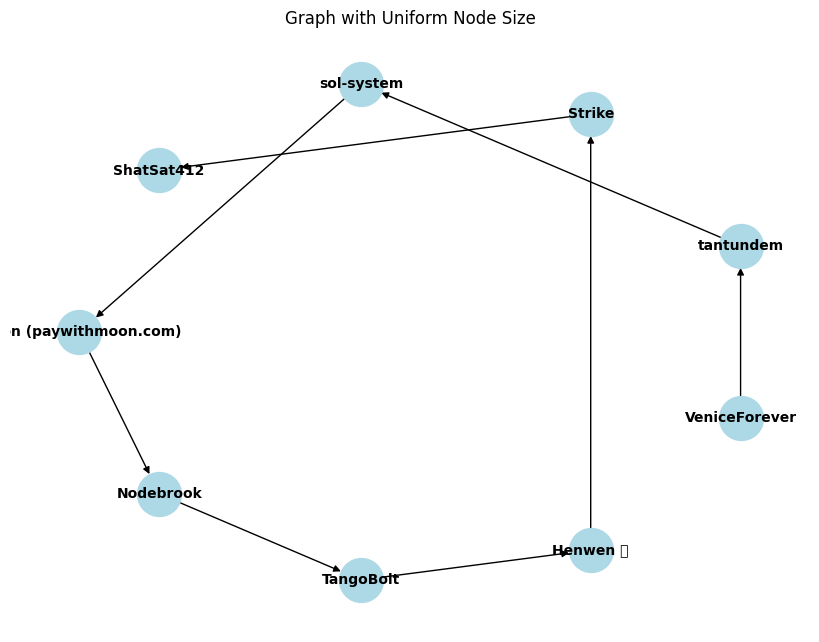

In [21]:
import networkx as nx
import matplotlib.pyplot as plt

# edges list construction
edges_df = final[["source-alias", "destination-alias"]]

G = nx.from_pandas_edgelist(edges_df, "source-alias", "destination-alias", create_using=nx.DiGraph())

#plt.figure(figsize=(8, 6))
#pos = nx.spring_layout(G)
#nx.draw(G, pos, with_labels=True, node_size=2000, node_color='lightblue', font_size=10, font_color='black', font_weight='bold', arrows=True)
#plt.title("Graph from DataFrame of Edges")
#plt.show()


plt.figure(figsize=(8, 6))
#pos = nx.spring_layout(G) 
#pos = nx.circular_layout(G)
#pos = nx.planar_layout(G)
pos = nx.shell_layout(G)
nx.draw(G, pos, with_labels=True, node_size=1000, node_color='lightblue', font_size=10, font_color='black', font_weight='bold', arrows=True)
plt.title("Graph with Uniform Node Size")
plt.show()

In [22]:
for i in nx.strongly_connected_components(G):
    print(i)

{'ShatSat412'}
{'Strike'}
{'Henwen 🐷'}
{'TangoBolt'}
{'Nodebrook'}
{'Moon (paywithmoon.com)'}
{'sol-system'}
{'tantundem'}
{'VeniceForever'}


In [23]:
final["amount"] = final["amount"].astype(float)
final["rate_fee"] = final["rate_fee"].astype(float)
final["base_fee"] = final["base_fee"].astype(float)
total_transaction_cost = sum(final["amount"] * final["rate_fee"] + final["base_fee"])
perc_cost = (total_transaction_cost * 100) / transaction_amount
print(f"Transacting {transaction_amount} sats costs {total_transaction_cost} ({perc_cost}% of transaction amount)")
print("Solver Status: ", results.solver[0]["System time"])

Transacting 200000 sats costs 22.201 (0.0111005% of transaction amount)
Solver Status:  3.15


/tmp/ipykernel_34702/930812685.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final["amount"] = final["amount"].astype(float)
/tmp/ipykernel_34702/930812685.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final["rate_fee"] = final["rate_fee"].astype(float)
/tmp/ipykernel_34702/930812685.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.

In [24]:
#from collections import Counter
#results = [tuple(i) for i in DF_channels_pos[["source-alias", "destination-alias"]].to_numpy()]
#unwrap = [e for i in results for e in i]
#extremes = [j for j in unwrap if Counter(unwrap)[j] == 1]
#def return_source(l: list):
#    if l[0] in [i for i, j in results]:
#        return l[0]
#    else: 
#        return l[1]
#sequence = []        
#source = return_source(extremes)
#sequence.append(source)
#while len(sequence) <= len(results):
#    for i,j in results:
#        if i == sequence[-1]:
#            sequence.append(j)
#for i in sequence:
#    print("⬇️", i)